# Проектная работа: Определение перспективного тарифа для телеком-компании

## Описание проекта

Необходимо выступить в роли аналитика компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

**Цель данной работы** состоит в том, чтобы определить, какой тариф лучше. Поэтому нашей **задачей** является предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

### Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Описание данных**:
- `user_id` — уникальный идентификатор пользователя;
- `age` — возраст пользователя (в годах);
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- `city` — город проживания пользователя;
- `first_name` — имя пользователя;
- `last_name` — фамилия пользователя;
- `reg_date` — дата подключения тарифа (день, месяц, год);
- `tariff` — название тарифного плана.

**План работы**:
1. Открытие файлов и изучение общей информации о данных;
2. Подготовка данных;
3. Анализ поведения пользователей;
4. Проверка гипотез;
5. Общие выводы.

### Шаг 1. Открытие файлов и изучение общей информации о данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# устанавливаем настройки представления данных
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:,.2f}".format)

##### 1.1. Информация о пользователях

In [2]:
users = pd.read_csv("users.csv")
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
# проверим количество уникальных пользователей по user_id
len(users["user_id"].unique())

500

In [5]:
display(users["age"].describe().round())

count   500.00
mean     47.00
std      17.00
min      18.00
25%      32.00
50%      46.00
75%      62.00
max      75.00
Name: age, dtype: float64

Таблица `users` содержит 500 строк и 8 столбцов. Каждая строка соответствует уникальному пользователю. Единственный столбец, где есть пропущенные данные, - `churn_date`. Типы данных в столбцах в целом кажутся, что соответствуют описанию тех данных, которые представлены в этих столбцах, кроме `reg_date` - тип данных в данном столбце можно заменить на `datetime`.

Самому молодому пользователю 18 лет, а самому старшему - 75 лет. Средний возраст пользователей - 47 лет.

##### 1.2. Информация о звонках

In [6]:
calls = pd.read_csv("calls.csv")
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [7]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


##### Описание данных
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

In [8]:
display(calls["duration"].describe().round())

count   202,607.00
mean          7.00
std           6.00
min           0.00
25%           1.00
50%           6.00
75%          11.00
max          38.00
Name: duration, dtype: float64

Таблица `calls` содержит 202607 строк и 4 столбца. Тип данных в столбце `call_date` можно изменить на `datetime`, чтобы иметь возможность приментять весь инструментарий применительно к датами. В остальных столбцах изменение типа данных не требуется. Пропущенные значения в таблице отсутствуют.

Средняя длительность звонков составляет 7 минут, а самый длительной резговор длился 38 минут. Длительность звонка в 0 минут означает пропущенный звонок.

##### 1.3. Информация о сообщениях

In [9]:
messages = pd.read_csv("messages.csv")
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


##### Описание данных
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `messages` содержит информацию о 123036 сообщениях, отправленных пользователями. Количество столбцов - 3, пропущенных значений нет. Информативным является столбец `message_date`, в котором тип данных можно изменить на `datetime`.

##### 1.4. Информация об интернет-сессиях

In [11]:
internet = pd.read_csv("internet.csv", index_col = 0)
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,"1,052.81",2018-09-07,1000
2,1000_2,"1,197.26",2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


##### Описание данных
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

In [13]:
display(internet["mb_used"].describe().round())

count   149,396.00
mean        370.00
std         278.00
min           0.00
25%         138.00
50%         348.00
75%         560.00
max       1,725.00
Name: mb_used, dtype: float64

Таблица `internet` состоит из 149396 строк и 4 столбцов. Тип данных можно поменять в столбце `session_date` на `datetime`.

За одну сессию в среднем пользователи расходовали 370 мегабайт. Однако вопрос возникает, почему минимальное значение объема потраченного интернет-трафика за сессию составляет 0 мегабайт. Данный момент необходимо отдельно проработать.

##### 1.5. Информация о тарифах

In [14]:
tariffs = pd.read_csv("tariffs.csv")
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


##### Описание данных
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `tariff_name` — название тарифа

Таблица `tariffs` является справочником по тарифам и содержит в себе их параметры. 

### Шаг 2. Подготовка данных

##### 2.1. Проверка дубликатов

In [16]:
for table in [users, calls, messages, internet, tariffs]:
    print(table.duplicated().sum())

0
0
0
0
0


Дубликаты в предоставленных данных отсутствуют.

##### 2.2. Нулевые значения в данных

In [17]:
print("Количество интернет-сессий в таблице internet:", "{:,.0f}".format(len(internet)))
print("Количество сессий с нулевым объемом потраченного интернет-трафика в таблице internet:",
      "{:,.0f}".format(len(internet[internet["mb_used"] == 0])))
print("Доля сессий с нулевым объемом потраченного интернет-трафика в таблице internet:",
     "{:,.2%}".format(len(internet[internet["mb_used"] == 0]) / len(internet)))

Количество интернет-сессий в таблице internet: 149,396
Количество сессий с нулевым объемом потраченного интернет-трафика в таблице internet: 19,598
Доля сессий с нулевым объемом потраченного интернет-трафика в таблице internet: 13.12%


Хотя и доля сессий с нулевым объемом потраченного интернет-трафика является немаленьким, от этих сессий можно как избавиться, так и оставить без изменений, потому что на выручке компании они не скажутся, однако это повод разобраться с разработчиками, откуда такие данные появились.

##### 2.3. Форматирование дат

In [18]:
# меняем типы данных на datetime
users["churn_date"] = pd.to_datetime(users["churn_date"], format = "%Y-%m-%d", errors = "ignore")
users["reg_date"] = pd.to_datetime(users["reg_date"], format = "%Y-%m-%d")
calls["call_date"] = pd.to_datetime(calls["call_date"], format = "%Y-%m-%d")
messages["message_date"] = pd.to_datetime(messages["message_date"], format = "%Y-%m-%d")
internet["session_date"] = pd.to_datetime(internet["session_date"], format = "%Y-%m-%d")

In [19]:
# в каждой таблице добавляем столбец со значением месяца
users["month"] = users["reg_date"].dt.month
calls["month"] = calls["call_date"].dt.month
messages["month"] = messages["message_date"].dt.month
internet["month"] = internet["session_date"].dt.month

In [20]:
# проверим результат форматирования данных
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


##### 2.4. Округление звонков в соответствии с политикой компании

In [21]:
# добавляем столбец с округленныой длительностью звонка
calls["duration"] = np.ceil(calls["duration"]).astype("int")

In [22]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


##### 2.5. Создание сводных таблиц для будущих расчетов

In [23]:
# сводная таблица по звонкам
calls_pitov_table = calls.pivot_table(index = ["user_id", "month"], 
                                      values = "duration", aggfunc = ["count", "sum"])
calls_pitov_table = calls_pitov_table.reset_index()
calls_pitov_table.columns = calls_pitov_table.columns.droplevel() 
calls_pitov_table.columns = ['user_id', 'month', 'calls', 'duration']
calls_pitov_table.head(15)

,user_id,month,calls,duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


In [24]:
# сводная таблица по сообщениям
messages_pivot_table = messages.pivot_table(index = ["user_id", "month"], values = "id", aggfunc = "count")
messages_pivot_table = messages_pivot_table.reset_index()
messages_pivot_table.columns = ["user_id", "month", "messages"]
messages_pivot_table.head(15)

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


In [25]:
# сводная таблица по интернет-трафику
internet_pivot_table = internet.pivot_table(index = ["user_id", "month"], values = "mb_used", aggfunc = "sum")
internet_pivot_table = internet_pivot_table.reset_index()
internet_pivot_table.columns = ["user_id", "month", "internet"]
internet_pivot_table.head(15)

,user_id,month,internet
0,1000,5,"2,253.49"
1,1000,6,"23,233.77"
2,1000,7,"14,003.64"
3,1000,8,"14,055.93"
4,1000,9,"14,568.91"
5,1000,10,"14,702.49"
6,1000,11,"14,756.47"
7,1000,12,"9,817.61"
8,1001,11,"18,429.34"
9,1001,12,"14,036.66"


In [26]:
# объединим таблицы для расчеты выручки по каждому пользователю
merged_table = pd.merge(calls_pitov_table, messages_pivot_table, how = "outer", on = ["user_id", "month"])
merged_table = pd.merge(merged_table, internet_pivot_table, how = "outer", on = ["user_id", "month"])
merged_table = pd.merge(merged_table, users[["user_id", "age", "city", "tariff"]], how = "outer", 
                       on = "user_id")
# проверим результат объединения таблиц
merged_table.head(15)

,user_id,month,calls,duration,messages,internet,age,city,tariff
0,1000,5.00,22.00,159.00,22.00,"2,253.49",52,Краснодар,ultra
1,1000,6.00,43.00,172.00,60.00,"23,233.77",52,Краснодар,ultra
2,1000,7.00,47.00,340.00,75.00,"14,003.64",52,Краснодар,ultra
3,1000,8.00,52.00,408.00,81.00,"14,055.93",52,Краснодар,ultra
4,1000,9.00,58.00,466.00,57.00,"14,568.91",52,Краснодар,ultra
5,1000,10.00,57.00,350.00,73.00,"14,702.49",52,Краснодар,ultra
6,1000,11.00,43.00,338.00,58.00,"14,756.47",52,Краснодар,ultra
7,1000,12.00,46.00,333.00,70.00,"9,817.61",52,Краснодар,ultra
8,1001,11.00,59.00,430.00,NaN,"18,429.34",41,Москва,smart
9,1001,12.00,63.00,414.00,NaN,"14,036.66",41,Москва,smart


In [27]:
# Если в какой-то из месяцев абонент не использовал сообщений или интернета, 
# то в объединенных данных появятся NaN, заменим их на нули.
columns = ["calls", "duration", "messages", "internet"]
for col in columns:
    merged_table[col] = merged_table[col].fillna(value = 0)
    print(merged_table[col].isna().sum())

0
0
0
0


In [28]:
merged_table.head(15)

,user_id,month,calls,duration,messages,internet,age,city,tariff
0,1000,5.00,22.00,159.00,22.00,"2,253.49",52,Краснодар,ultra
1,1000,6.00,43.00,172.00,60.00,"23,233.77",52,Краснодар,ultra
2,1000,7.00,47.00,340.00,75.00,"14,003.64",52,Краснодар,ultra
3,1000,8.00,52.00,408.00,81.00,"14,055.93",52,Краснодар,ultra
4,1000,9.00,58.00,466.00,57.00,"14,568.91",52,Краснодар,ultra
5,1000,10.00,57.00,350.00,73.00,"14,702.49",52,Краснодар,ultra
6,1000,11.00,43.00,338.00,58.00,"14,756.47",52,Краснодар,ultra
7,1000,12.00,46.00,333.00,70.00,"9,817.61",52,Краснодар,ultra
8,1001,11.00,59.00,430.00,0.00,"18,429.34",41,Москва,smart
9,1001,12.00,63.00,414.00,0.00,"14,036.66",41,Москва,smart


##### 2.6. Расчет помесячной выручки по каждому пользователю

In [29]:
# напишем функцию для расчета помесячной выручки по каждому пользователю
# функция принимает на вход строку
def revenue(row):
    
    # из таблицы tariffs вытянем нужную строку с информацией о тарифе
    tariff = tariffs[tariffs["tariff_name"] == row["tariff"]]
    
    # начнем формировать будущую выручку с абонентской платы
    monthly_fee = int(tariff["rub_monthly_fee"])
    
    # посчитаем плату за потраченные минуты сверх тарифа
    extra_calls = float((row["calls"] - tariff["minutes_included"]) * tariff["rub_per_minute"])
    
    # посчитаем плату за отправленные сообщения сверх тарифа
    extra_messages = float((row["messages"] - tariff["messages_included"]) * tariff["rub_per_message"])
    
    # посчитаем плату за объем использованного интернет-трафика сверх тарифа
    extra_internet = float(np.ceil((row["internet"] - tariff["mb_per_month_included"]) / 1024) 
                           * tariff["rub_per_gb"])
    
    # если дополнительная плата есть, то добавим ее в общую выручку с абонента
    if extra_calls > 0:
         monthly_fee += extra_calls
    if extra_messages > 0:
         monthly_fee += extra_messages
    if extra_internet > 0:
         monthly_fee += extra_internet
    
    return monthly_fee

In [30]:
# проверим корректность выполнения функции на тестовой выборке
test_sample = merged_table.sample(15)
test_sample

,user_id,month,calls,duration,messages,internet,age,city,tariff
2964,1466,5.00,73.00,492.00,0.00,"14,927.91",37,Новосибирск,ultra
803,1127,6.00,30.00,208.00,87.00,"14,152.09",26,Казань,smart
2242,1359,11.00,110.00,741.00,12.00,"16,779.28",52,Москва,smart
2669,1421,6.00,49.00,242.00,52.00,"15,761.86",30,Калининград,smart
3211,1489,10.00,0.00,0.00,21.00,"19,559.44",35,Санкт-Петербург,smart
3056,1479,8.00,65.00,396.00,0.00,"17,035.14",40,Хабаровск,smart
1501,1240,10.00,43.00,308.00,0.00,"34,506.22",30,Воронеж,ultra
1007,1161,7.00,37.00,296.00,44.00,"19,542.37",65,Набережные Челны,smart
1359,1216,12.00,198.00,"1,435.00",64.00,"20,066.05",74,Волгоград,smart
986,1157,11.00,48.00,408.00,0.00,"19,122.04",27,Москва,smart


In [31]:
print(test_sample.apply(revenue, axis = 1))

2964   1,950.00
803      661.00
2242     950.00
2669     756.00
3211   1,550.00
3056     950.00
1501   2,550.00
1007   1,550.00
1359   1,592.00
986    1,350.00
1110     550.00
1694   1,950.00
1934   1,950.00
1749   1,950.00
224      553.00
dtype: float64


In [32]:
# применим функцию revenue к всему набору данных
merged_table["monthly_fee"] = merged_table.apply(revenue, axis = 1)
merged_table.head(15)

,user_id,month,calls,duration,messages,internet,age,city,tariff,monthly_fee
0,1000,5.00,22.00,159.00,22.00,"2,253.49",52,Краснодар,ultra,"1,950.00"
1,1000,6.00,43.00,172.00,60.00,"23,233.77",52,Краснодар,ultra,"1,950.00"
2,1000,7.00,47.00,340.00,75.00,"14,003.64",52,Краснодар,ultra,"1,950.00"
3,1000,8.00,52.00,408.00,81.00,"14,055.93",52,Краснодар,ultra,"1,950.00"
4,1000,9.00,58.00,466.00,57.00,"14,568.91",52,Краснодар,ultra,"1,950.00"
5,1000,10.00,57.00,350.00,73.00,"14,702.49",52,Краснодар,ultra,"1,950.00"
6,1000,11.00,43.00,338.00,58.00,"14,756.47",52,Краснодар,ultra,"1,950.00"
7,1000,12.00,46.00,333.00,70.00,"9,817.61",52,Краснодар,ultra,"1,950.00"
8,1001,11.00,59.00,430.00,0.00,"18,429.34",41,Москва,smart,"1,150.00"
9,1001,12.00,63.00,414.00,0.00,"14,036.66",41,Москва,smart,550.00


### Шаг 3. Анализ поведения пользователей

##### 3.1. Поведение пользователей тарифа Ultra

In [33]:
# основные условия тарифного плата Ultra
tariffs[tariffs["tariff_name"] == "ultra"]

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra


In [34]:
ultra_users = merged_table[merged_table["tariff"] == "ultra"].groupby("user_id").mean()
ultra_users = ultra_users.drop("month", axis = 1)
ultra_users.describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
calls,149.00,72.95,39.56,0.00,7.00,44.00,72.00,102.00,140.60,164.16,170.00
duration,149.00,524.28,284.14,0.00,45.74,320.75,513.33,746.33,"1,021.45","1,169.80","1,179.36"
messages,149.00,53.67,46.42,0.00,0.00,14.00,45.00,84.00,144.80,174.56,192.00
internet,149.00,"19,443.27","8,436.86",0.00,"5,552.27","13,550.78","18,685.46","25,801.39","32,821.10","36,889.88","38,463.57"
age,149.00,46.90,16.92,18.00,20.40,31.00,46.00,63.00,73.00,75.00,75.00
monthly_fee,149.00,"2,085.55",297.73,"1,950.00","1,950.00","1,950.00","1,950.00","1,987.50","2,850.00","3,173.00","3,225.00"


В среднем пользователи тарифа "Ультра" совершают 73 звонка в месяц общей длительностью 524 минут, отправляют 54 смс и используют практически 19.5 Гб трафика. При этом получается, что всем пользователям хватает месячного пакета звонков и смс, и только интернет-трафик выходит за пределы лимитов. Это видно и по среднему количеству потраченных пользователем за месяц денег.

In [35]:
# доля пользователей со средним платежом в месяц большим, чем абонентская плата
print("Доля пользователей тарифа Ultra со средним платежом в месяц большим, чем абонентская плата:",
      "{:.2%}".format(len(ultra_users[ultra_users["monthly_fee"] > 1950]) / len(ultra_users))) 

Доля пользователей тарифа Ultra со средним платежом в месяц большим, чем абонентская плата: 28.86%


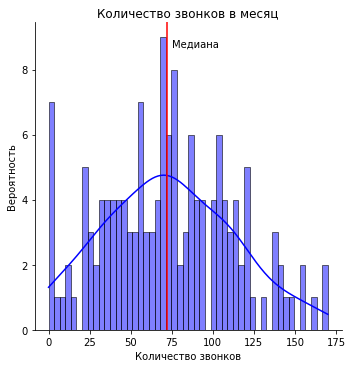

In [36]:
sns.displot(ultra_users["calls"], bins = 50, kde = True, color = 'blue')
plt.axvline(72, 0, color = "red")
plt.text(75, 8.7, 'Медиана')
plt.title('Количество звонков в месяц')
plt.xlabel('Количество звонков')
plt.ylabel('Вероятность')
plt.show()

Среднее и максимальное количество звонков в месяц меньше у пользователей тарифного плана "Смарт", но распределение количества звонков у пользователей тарифного плана "Ультра" шире - то есть некоторые из них звонят чаще. 

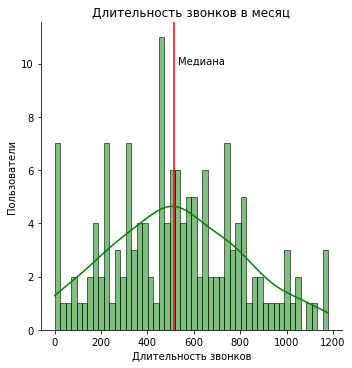

In [37]:
sns.displot(ultra_users["duration"], bins = 50, kde = True, color = 'green')
plt.axvline(513.33, 0, color = "red")
plt.text(530, 10, 'Медиана')
plt.title('Длительность звонков в месяц')
plt.xlabel('Длительность звонков')
plt.ylabel('Пользователи')
plt.show()

Общая длительность звонков пользователей "Ультра" не добирается и до половины пакета (3000 минут) - максимальная немногим больше 1000 минут в месяц.

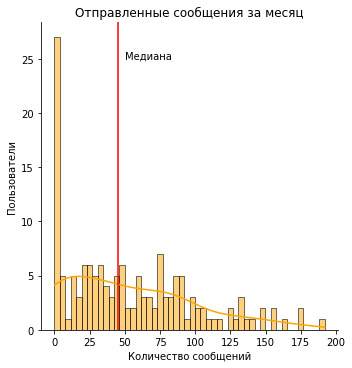

In [38]:
sns.displot(ultra_users["messages"], bins = 50, kde = True, color = 'orange')
plt.axvline(45, 0, color = "red")
plt.text(50, 25, 'Медиана')
plt.title('Отправленные сообщения за месяц')
plt.xlabel('Количество сообщений')
plt.ylabel('Пользователи')
plt.show()

Общее количество отправленных сообщений пользователей "Ультра" не добирается и до четверти пакета (1000 сообщений) - максимальное количество меньше 200 за месяц.

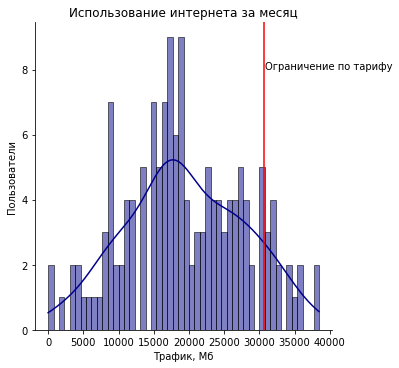

In [39]:
sns.displot(ultra_users["internet"], bins = 50, kde = True, color = 'darkblue')
plt.axvline(30720, 0, color = "red")
plt.text(30800, 8, 'Ограничение по тарифу')
plt.title('Использование интернета за месяц')
plt.xlabel('Трафик, Мб')
plt.ylabel('Пользователи')
plt.show()

Объем использованного трафика пользователей "Ультра" примерно у 11% пользователей превышает пакет, максимальное достигает 38 Гб (на 20% больше, чем включенные в абонентскую плату 30Гб).

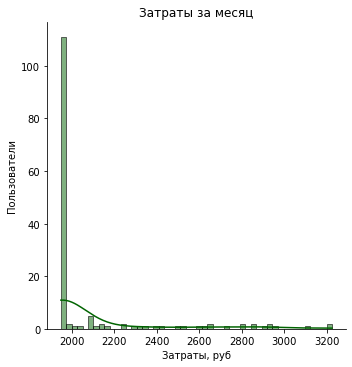

In [40]:
sns.displot(ultra_users["monthly_fee"], bins = 50, kde = True, color = 'darkgreen')
plt.title('Затраты за месяц')
plt.xlabel('Затраты, руб')
plt.ylabel('Пользователи')
plt.show()

Так как почти все затраты, кроме интернет-трафика, у пользователей "Ультра" укладываются в пакеты, то и большинство пользователей платит только абонентскую плату (доля таких пользователей - более 70%).

##### 3.2. Поведение пользователей тарифа Smart

In [41]:
# основные условия тарифного плата Smart
tariffs[tariffs["tariff_name"] == "smart"]

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart


In [42]:
smart_users = merged_table[merged_table["tariff"] == "smart"].groupby("user_id").mean()
smart_users = smart_users.drop("month", axis = 1)
smart_users.describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
calls,351.00,58.48,20.31,0.00,27.00,43.33,60.00,72.00,90.50,99.50,121.00
duration,351.00,418.44,146.55,0.00,186.83,315.96,424.88,518.62,656.92,717.26,891.50
messages,351.00,32.26,26.53,0.00,0.00,11.00,27.50,48.00,84.50,103.00,118.00
internet,351.00,"16,134.52","3,676.97",0.00,"9,993.00","13,865.00","16,246.75","18,585.12","21,919.69","24,234.17","27,286.96"
age,351.00,46.46,16.58,18.00,21.00,32.00,47.00,62.00,72.00,74.00,75.00
monthly_fee,351.00,"1,185.36",539.19,550.00,550.00,750.00,"1,064.29","1,510.00","2,201.00","2,718.75","3,562.33"


В среднем пользователи "Смарт" совершают 59 звонков в месяц общей длительностью 419 минут, отправляют 33 смс и используют чуть больше 16 Гб интернет-трафика. При этом получается, что чуть больше, чем половине пользователей хватает месячного пакета звонков, почти всем хватает смс, а интернет-трафик выходит за пределы лимитов у более чем половины пользователей. Это видно и по среднему количеству потраченных пользователем за месяц денег - 5% пользователей вносят только абонентскую плату и ничего сверх нее, но не каждый месяц все пользователи переплачивают - если брать не сгруппированные данные, то всего 75% записей о тратах выходят за пределы абонентской платы.

In [43]:
# доля пользователей со средним платежом в месяц большим, чем абонентская плата
print("Доля пользователей тарифа Smart со средним платежом в месяц большим, чем абонентская плата:",
      "{:.2%}".format(len(smart_users[smart_users["monthly_fee"] > 550]) / len(smart_users))) 

Доля пользователей тарифа Smart со средним платежом в месяц большим, чем абонентская плата: 91.17%


In [44]:
print("Доля пользователей тарифа Smart, которые укладываются в тарифные ограничения по количеству минут:", 
      "{:.0%}".format(stats.percentileofscore(smart_users["duration"], 500, kind = "weak") / 100))

Доля пользователей тарифа Smart, которые укладываются в тарифные ограничения по количеству минут: 71%


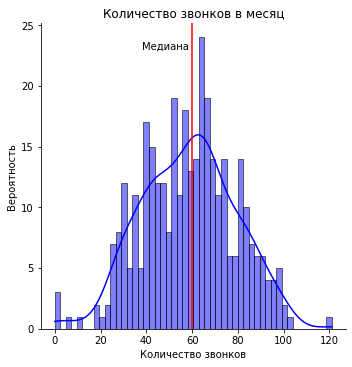

In [45]:
sns.displot(smart_users["calls"], bins = 50, kde = True, color = 'blue')
plt.axvline(60, 0, color = "red")
plt.text(38, 23, 'Медиана')
plt.title('Количество звонков в месяц')
plt.xlabel('Количество звонков')
plt.ylabel('Вероятность')
plt.show()

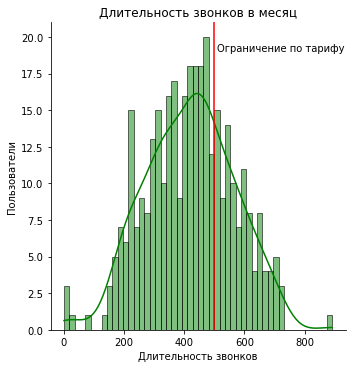

In [46]:
sns.displot(smart_users["duration"], bins = 50, kde = True, color = 'green')
plt.axvline(500, 0, color = "red")
plt.text(510, 19, 'Ограничение по тарифу')
plt.title('Длительность звонков в месяц')
plt.xlabel('Длительность звонков')
plt.ylabel('Пользователи')
plt.show()

Общая длительность звонков пользователей "Смарт" может и в полтора раза превысить объем, включенный в пакет, а средняя длительность - 420 минут из 500 в месяц. Пакета хватает примерно 71% пользователей.

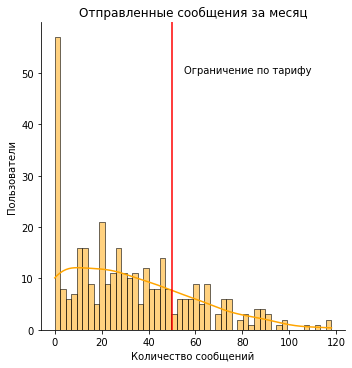

In [47]:
sns.displot(smart_users["messages"], bins = 50, kde = True, color = 'orange')
plt.axvline(50, 0, color = "red")
plt.text(55, 50, 'Ограничение по тарифу')
plt.title('Отправленные сообщения за месяц')
plt.xlabel('Количество сообщений')
plt.ylabel('Пользователи')
plt.show()

Общее количество сообщений пользователей "Смарт" может даже в два раза превысить объем, включенный в пакет, но примерно 77% пользователей пакета хватает.

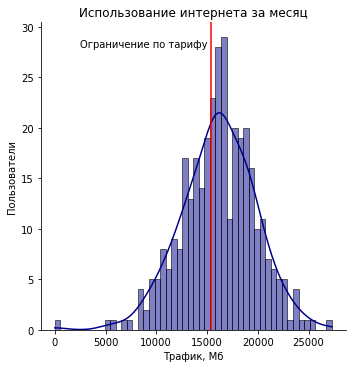

In [48]:
sns.displot(smart_users["internet"], bins = 50, kde = True, color = 'darkblue')
plt.axvline(15360, 0, color = "red")
plt.text(2500, 28, 'Ограничение по тарифу')
plt.title('Использование интернета за месяц')
plt.xlabel('Трафик, Мб')
plt.ylabel('Пользователи')
plt.show()

Общее количество трафика пользователей "Смарт" может на 80% превысить объем, включенный в пакет, всего 39% пользователей не докупают дополнительного интернета.

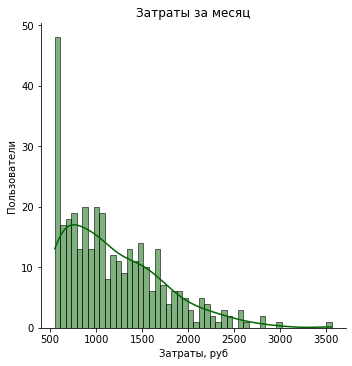

In [49]:
sns.displot(smart_users["monthly_fee"], bins = 50, kde = True, color = 'darkgreen')
plt.title('Затраты за месяц')
plt.xlabel('Затраты, руб')
plt.ylabel('Пользователи')
plt.show()

Пользователи "Смарт" переплачивают гораздо чаще - всего 5% пользователей в среднем используют только включенные в абонентскую плату услуги. 

### Выводы
---
Пользователей "Смарт" в выборке в три раза больше и в среднем каждый из них тратит меньшую сумму в месяц, но при этом значительная доля пользователей докупает дополнительные пакеты услуг. Пользователи "Ультра" пользуются только основными пакетами звонков и смс, и три четверти пользователей платят только абонентскую плату.

### Шаг 4. Проверка гипотез

##### 4.1. Гипотеза №1

Проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

**Н0**: "средняя выручка одинаковая вне зависимости от тарифа". <br> 
**H1**: "средняя выручка отличается".

Значение критического уровня вероятности (альфа) принимается равным 5%.

In [50]:
# проверим на средних данных по пользователям
alpha = 0.05  # критический уровень статистической значимости
results = stats.ttest_ind(ultra_users['monthly_fee'], smart_users['monthly_fee'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 9.425726532573722e-62
Отвергаем нулевую гипотезу


In [51]:
# проверим на данных по отдельным месячным тратам пользователей
alpha = 0.05  # критический уровень статистической значимости
results = stats.ttest_ind(merged_table[merged_table['tariff'] == 'ultra']['monthly_fee'], 
                       merged_table[merged_table['tariff'] == 'smart']['monthly_fee'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 8.348899169074068e-243
Отвергаем нулевую гипотезу


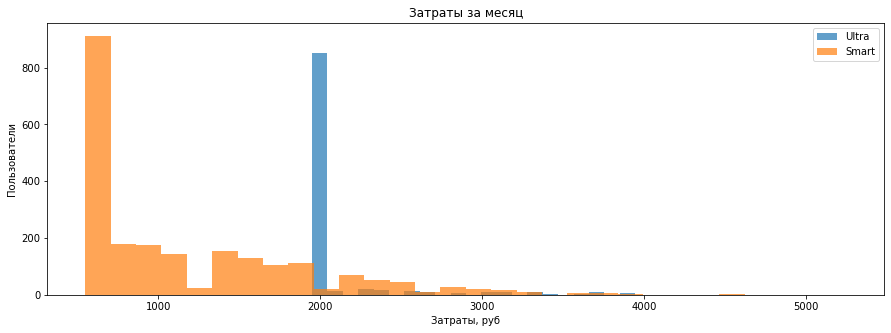

In [52]:
# график распределения
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(merged_table[merged_table['tariff'] == 'ultra']['monthly_fee'], 30, alpha=0.7, label='Ultra')
ax.hist(merged_table[merged_table['tariff'] == 'smart']['monthly_fee'], 30, alpha=0.7, label='Smart')
plt.title('Затраты за месяц')
plt.xlabel('Затраты, руб')
plt.ylabel('Пользователи')
plt.legend(loc = 0)
plt.show()

Вне зависимости от того, берем мы платежи пользователей в отдельные месяцы или усредненные суммы для каждого пользователя, p-value получается микроскопическим, значит, вероятность, что наборы данных из одной совокупности, крайне мала. На основании принятого нами уровня статистической значимости 5% мы можем предполагать, что наша гипотеза не верна.

##### 4.2. Гипотеза №2

Проверим гипотезу о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**H0**: "выручка в разных городах не отличается". <br>
**H1**: "выручка имеет различия".

In [53]:
# сравним пользователей Ultra из разных регионов
alpha = 0.05  # критический уровень статистической значимости
results = stats.ttest_ind(
    merged_table[(merged_table['city'] == 'Москва') & (merged_table['tariff'] == 'ultra')]['monthly_fee'], 
    merged_table[(merged_table['city'] != 'Москва') & (merged_table['tariff'] == 'ultra')]['monthly_fee']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.8570628563121833
Не получилось отвергнуть нулевую гипотезу


In [54]:
# сравним пользователей Smart из разных регионов
alpha = 0.05  # критический уровень статистической значимости
results = stats.ttest_ind(
    merged_table[(merged_table['city'] == 'Москва') & (merged_table['tariff'] == 'smart')]['monthly_fee'], 
    merged_table[(merged_table['city'] != 'Москва') & (merged_table['tariff'] == 'smart')]['monthly_fee']
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.2004823192955272
Не получилось отвергнуть нулевую гипотезу


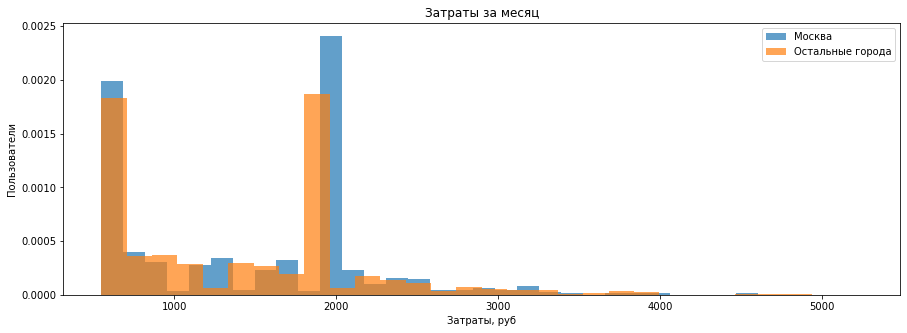

In [55]:
# график распределения
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(merged_table[merged_table['city'] == 'Москва']['monthly_fee'], 30, alpha = 0.7,
        label = 'Москва', density = True)
ax.hist(merged_table[merged_table['city'] != 'Москва']['monthly_fee'], 30, alpha = 0.7,
        label = 'Остальные города', density = True)
plt.title('Затраты за месяц')
plt.xlabel('Затраты, руб')
plt.ylabel('Пользователи')
plt.legend(loc = 0)
plt.show()

### Выводы
---
Распределение потраченных минут на звонки пользователями тарифного плана "Смарт":
- среднее: 419
- дисперсия: 147
- отклонение: 21609

Распределение потраченных минут на звонки пользователями тарифного плана "Ультра":
- среднее: 525
- дисперсия: 284
- отклонение: 80656

Распределение отправленных сообщений пользователями тарифного плана "Смарт":
- среднее: 33
- дисперсия: 27
- отклонение: 729

Распределение отправленных сообщений пользователями тарифного плана "Ультра":
- среднее: 54
- дисперсия: 47
- отклонение: 2209

Распределение использованного интернет-трафика в мегабайтах пользователями тарифного плана "Смарт":
- среднее: 16135
- дисперсия: 3677
- отклонение: 13520329

Распределение использованного интернет-трафика в мегабайтах пользователями тарифного плана "Ультра":
- среднее: 19444
- дисперсия: 8437
- отклонение: 71182969

Распределение затра пользователями тарифного плана "Смарт":
- среднее: 1186
- дисперсия: 540
- отклонение: 291600

Распределение затрат пользователями тарифного плана "Ультра":
- среднее: 2086
- дисперсия: 298
- отклонение: 88804

Таким образом, большинство пользователей тарифа "Смарт" используют больше услуг, чем включено в базовые пакеты, и платят суммарно до двух раз больше, чем базовая абонентская плата. Но даже с учетом дополнительных зарат средний месячный платеж меньше, чем на тарифе "Ультра". 

Большинство пользователей тарифа "Ультра" платят только абонентскую плату и некоторые докупают пакет интернета.
Затраты пользователей из Москвы не отличается статистически значимо от затрат пользователей из регионов.

Для более точной оценки выгоды для мобильного оператора нужно учесть себестоимость минуты, сообщения и мегабайта трафика - пользователи "Ультра" расходуют гораздо меньше услуг, чем включено в пакеты, но платят за них, в то время как пользователи "Смарт" чаще используют пакеты полностью.